In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

root = '/kaggle/input/merged-fer/new_fer_data'

In [4]:
classes = []
file_paths = []

In [5]:
for class_name in os.listdir(root):
    for file in os.listdir(os.path.join(root,class_name)):
        classes.append(class_name)
        file_paths.append(os.path.join(os.path.join(root,class_name),file))

In [6]:
classes[:5]

['surprise', 'surprise', 'surprise', 'surprise', 'surprise']

In [7]:
df = pd.DataFrame({"classes":classes,"file_paths":file_paths})

In [8]:
df.head()

,classes,file_paths
0,surprise,/kaggle/input/merged-fer/new_fer_data/surprise...
1,surprise,/kaggle/input/merged-fer/new_fer_data/surprise...
2,surprise,/kaggle/input/merged-fer/new_fer_data/surprise...
3,surprise,/kaggle/input/merged-fer/new_fer_data/surprise...
4,surprise,/kaggle/input/merged-fer/new_fer_data/surprise...


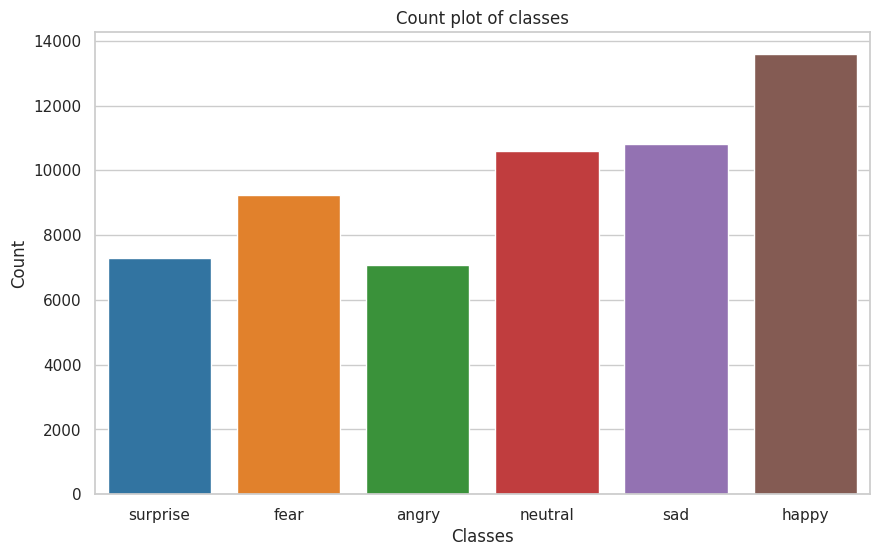

In [14]:
sns.set(style='whitegrid')

# Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='classes', palette='tab10')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Count plot of classes')

# Display the plot
plt.show()


In [16]:
from sklearn.utils import resample

# Calculate the class distribution
class_counts = df['classes'].value_counts()

# Find the maximum count (largest class size)
min_count = class_counts.min()

# Initialize an empty list to store balanced data
balanced_data = []

# Iterate through each class
for cls in class_counts.index:
    # Get all rows for the current class
    class_rows = df[df['classes'] == cls]
    
    if class_counts[cls] > min_count:
        # Perform oversampling for the current class
        resampled_rows = resample(class_rows, replace=True, n_samples=max_count, random_state=42)
    else:
        # No resampling needed if the class is already of max_count size
        resampled_rows = class_rows
    
    # Append the resampled rows to the balanced data list
    balanced_data.append(resampled_rows)

# Concatenate the balanced data list to create a balanced DataFrame
balanced_df = pd.concat(balanced_data)

# Shuffle the balanced DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Now balanced_df contains balanced data based on classes
print(balanced_df['classes'].value_counts())

# Use balanced_df for your subsequent analysis


classes
fear        7075
happy       7075
neutral     7075
surprise    7075
angry       7075
sad         7075
Name: count, dtype: int64


In [17]:
balanced_df.head()

,classes,file_paths
0,fear,/kaggle/input/merged-fer/new_fer_data/fear/267...
1,happy,/kaggle/input/merged-fer/new_fer_data/happy/Tr...
2,neutral,/kaggle/input/merged-fer/new_fer_data/neutral/...
3,neutral,/kaggle/input/merged-fer/new_fer_data/neutral/...
4,fear,/kaggle/input/merged-fer/new_fer_data/fear/164...


In [18]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input


# Define image size for EfficientNet
image_size = (224, 224)

# Create an instance of ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,  # EfficientNet-specific preprocessing
                             rescale=1.0 / 255.0,  # Rescale pixel values to the range [0, 1]
                             validation_split=0.2)  # Split data for training and validation

# Define training, validation, and test data generators
train_generator = datagen.flow_from_dataframe(balanced_df,
                                              x_col='file_paths',
                                              y_col='classes',
                                              target_size=image_size,
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='training')  # Training subset

validation_generator = datagen.flow_from_dataframe(balanced_df,
                                                   x_col='file_paths',
                                                   y_col='classes',
                                                   target_size=image_size,
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   subset='validation')  # Validation subset

# For test data, you can use the whole DataFrame without splitting
test_generator = datagen.flow_from_dataframe(balanced_df,
                                             x_col='file_paths',
                                             y_col='classes',
                                             target_size=image_size,
                                             batch_size=32,
                                             class_mode='categorical',
                                             shuffle=False)  # Test data should be shuffled based on model needs


2024-04-16 11:46:15.191602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 11:46:15.191717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 11:46:15.313214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 33960 validated image filenames belonging to 6 classes.
Found 8490 validated image filenames belonging to 6 classes.
Found 42450 validated image filenames belonging to 6 classes.


In [20]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Define base model with EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output_layer = Dense(6, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=output_layer)

# Freeze base model layers (you can unfreeze them later if you want to fine-tune)
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the data generators
history = model.fit(train_generator,
          validation_data=validation_generator,
          epochs=10,
          batch_size=32)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# The `history` object contains training and validation loss and accuracy for each epoch, which you can use for analysis.


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/1062 ━━━━━━━━━━━━━━━━━━━━ 27:25:40 93s/step - accuracy: 0.1250 - loss: 1.9720

I0000 00:00:1713268180.100337      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713268180.247156      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 304s 199ms/step - accuracy: 0.3854 - loss: 1.5288 - val_accuracy: 0.4735 - val_loss: 1.3302
Epoch 2/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 140s 131ms/step - accuracy: 0.5356 - loss: 1.2035 - val_accuracy: 0.5339 - val_loss: 1.2083
Epoch 3/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 139s 130ms/step - accuracy: 0.5994 - loss: 1.0662 - val_accuracy: 0.5226 - val_loss: 1.2868
Epoch 4/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 141s 132ms/step - accuracy: 0.6656 - loss: 0.9023 - val_accuracy: 0.5922 - val_loss: 1.1212
Epoch 5/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 139s 131ms/step - accuracy: 0.7225 - loss: 0.7574 - val_accuracy: 0.6090 - val_loss: 1.2206
Epoch 6/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 138s 130ms/step - accuracy: 0.7798 - loss: 0.6058 - val_accuracy: 0.6051 - val_loss: 1.2495
Epoch 7/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 140s 132ms/step - accuracy: 0.8194 - loss: 0.4952 - val_accuracy: 0.6399 - val_loss: 1.1956
Epoch 8/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 139s 131ms/step - accuracy: 0.8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


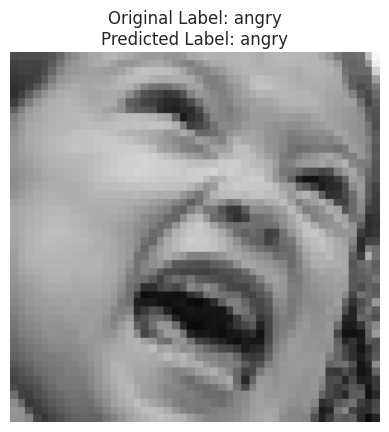

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Load a sample image and its corresponding label from the test data generator
sample_image_batch, sample_label_batch = next(test_generator)

# We use the first image in the batch as the sample image
sample_image = sample_image_batch[0]
sample_label = sample_label_batch[0]

# Make a prediction on the sample image using the trained model
predicted_probabilities = model.predict(np.expand_dims(sample_image, axis=0))

# Get the index of the maximum probability to determine the predicted class
predicted_class_index = np.argmax(predicted_probabilities)

# Map the predicted class index to its corresponding label name
class_indices = test_generator.class_indices
predicted_class_name = list(class_indices.keys())[list(class_indices.values()).index(predicted_class_index)]

# Get the original label index (the index with the value of 1 in the one-hot encoded label)
original_class_index = np.argmax(sample_label)

# Map the original class index to its corresponding label name
original_class_name = list(class_indices.keys())[list(class_indices.values()).index(original_class_index)]

# Plot the sample image
plt.imshow(sample_image)
plt.axis('off')  # Hide the axes

# Add a title showing the original label and the predicted label
plt.title(f'Original Label: {original_class_name}\nPredicted Label: {predicted_class_name}')

# Display the plot
plt.show()


In [24]:
# Assuming your Keras model is named `model`

# Save the model in Keras format
model.save('my_model.h5')

print("Keras model saved as 'my_model.h5'")


Keras model saved as 'my_model.h5'
